# golive2

## Introduction


The notebook continues the narrative of the **golive** Jupyter notebook on land ice velocities near 
Malaspina Glacier. Whereas **golive** was concerned with 6 separate results **golive2** extends this
to all 255 golive results available, all derived from LANDSAT imaging at Path 63 Row 18. 
Each velocity grid is produced from a pair of images separated by a multiple of 16 days, up to
a maximum of 96 days. Some center times are coincident within this set of results; they are 
disambiguated by adding arbitrary hour offsets as necessary.


Each NetCDF data file maps in code to an xarray *DataSet* where we wish to consider the time series
as a whole. To that end we use the xarray method *open_mfdataset* (open multiple-files-dataset) where
the slight spatial misregistration between files is handled transparently by xarray.


Within this DataSet are particular DataArray objects denoted as **Data variables**. Of particular 
interest is the ice speed `vv_masked` and the land/glacier/ocean mask `lgo_mask`. The latter has
values at each pixel of 0, 1 or 2 for glacier, land and ocean respectively. For time-series 
analysis we use the `xarray.Dataset.load()` method to read the data into program memory. This
avoids repeating 255 consecutive file open/close operations.


Here are some open questions concerning these data...

* Does masking help clarify results e.g. by checking velocity direction agreement, invoking `lgo_mask` etc 
  * lgo_mask varies slightly from one result to the next
  * some pixels have unrealistically high velocities (noise)
* What does standard deviation / mean look like? 
* What does 2013 speed / mean speed look like? (2013 shows as higher speed on Seward Glacier)


## Part 1. Data loader

* Consolidate 255 data files into a single Dataset
* load certain DataArrays into memory

In [1]:
%matplotlib inline
import timeit
from datetime import timedelta
from matplotlib import pyplot as plt
import pandas as pd
import netCDF4
import xarray as xr
import numpy as np
from ipywidgets import *                # interactivity
from traitlets import dlink             # interactivity
import sys
import os
from pathlib import Path

# geoscience tools
!pip install utm
!pip install pygeotools
import utm

from osgeo import gdal 
from pygeotools.lib import iolib,timelib


home_d = str(Path.home()) + '/'
data_d = home_d + 'data/'             # A non-repository location for datasets of interest

def dirobj(obj): return [x for x in dir(obj) if not x.startswith('_')]

def lsal(path=''):
    import os
    return os.popen('ls -al ' + path).readlines()

def ShowGitHubImage(username, repo, folder, source, localpath, localname, width, height):
    global home_d
    import requests, shutil
    from PIL import Image
    outf = localpath + '/' + localname
    f = 'https://raw.githubusercontent.com/' + username + '/' + repo + '/master/' + folder + '/' + source
    a = requests.get(f, stream = True)
    if a.status_code == 200:
        with open(outf, 'wb') as f:
            a.raw.decode_content = True
            shutil.copyfileobj(a.raw, f)
    return Image.open(outf).resize((width,height),Image.ANTIALIAS)

def ShowLocalImage(path, filename, width, height):
    from PIL import Image
    f = path + '/' + filename 
    return Image.open(f).resize((width,height),Image.ANTIALIAS)

# Test either of the 'Show Image' functions
# ShowGitHubImage('robfatland', 'othermathclub', 'images/cellular', 'conus_textile_shell_2.png', home_d, 'ctextile.jpg', 450, 250)
# ShowLocalImage(home_d, 'ctextile.jpg', 450, 250)

You are using pip version 9.0.1, however version 19.0.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
You are using pip version 9.0.1, however version 19.0.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [2]:
# file grabbing code... this takes a few minutes 
golive2_d = data_d + 'golive2/'

if False:
    ftp = FTP('dtn.rc.colorado.edu')
    ftp.login()
    ftp.cwd('work/nsidc0710/nsidc0710_landsat8_golive_ice_velocity_v1.1/p063_r018')
    a=[]
    ftp.dir(a.append)    # This is a rather tricky line of Python as it passes an append method as an argument
    d = [b.split()[8] for b in a if len(b.split()) == 9 and b.split()[8][-3:]=='.nc']
    for i in range(len(d)):
        ftp.retrbinary('RETR ' + d[i], open(golive2_d + d[i], 'wb').write)  
        print('obtained file', i)
    ftp.quit()
    print(len(d))
    # for c in d: print(c)

In [3]:
%%time
# Here are various attempts to dispense with the chars/processing_log stuff; but they are not to the point.
#   Various attempts to drop of squeeze produced affects; but the issue of sorting the source .nc files
#   was related to the need for a sortable dimension which proves to be time.
#
#ds1
#ds1.squeeze('chars', drop=True)
#ds1['vv_masked'].sel(x=':', )
#del ds1['chars']
#ds1 = ds1.sel(x=slice(-1), y=slice(-1))
#ds1
# def pp(ds1):
#     del ds1['processing_log']
#     del ds1['chars']
#     ds1.rename({'chars':'band'},inplace=True)
#     return ds1.assign_coords(band=1)

tslist = []

def pp(ds):
    global tslist
    s = ds['image_pair_times'].attrs['mid_date']
    ts = pd.Timestamp(s)
    while ts in tslist: ts += timedelta(hours = 1)
    tslist.append(ts)
    ds['time'] = xr.Variable('time', [ts])
    return ds

m = xr.open_mfdataset(golive2_d + '*.nc', preprocess = pp, decode_cf=False, autoclose=True, concat_dim='time')

print('there are', len(tslist), 'files in play')

there are 255 files in play
CPU times: user 3min 37s, sys: 21.6 s, total: 3min 59s
Wall time: 4min 2s


In [4]:
%%time

# Briefly print some views into the data...
# print(m)
print(len(m['time']), '\n')
print(type(m['time'].values), '\n')
print(m['time'], '\n')
print(m['image_pair_times'], '\n')
print(m['image_pair_times'].time.values[200], '\n')
print(type(m['corr']), '\n')

# From m as the grand Dataset (255 results in time-series): load key DataArrays into memory
vv = m['vv_masked'].load()
lgo = m['lgo_mask'].load()

# Adding these in *may* be too much for the available RAM (killing the Python kernel)
# corr = m['corr'].load()
# north = m['y'].load()
# east = m['x'].load()
# time = m['time'].load()

255 

<class 'numpy.ndarray'> 

<xarray.DataArray 'time' (time: 255)>
array(['2013-05-07T00:00:00.000000000', '2013-05-15T00:00:00.000000000',
       '2013-05-23T00:00:00.000000000', ..., '2018-08-25T01:00:00.000000000',
       '2018-09-02T00:00:00.000000000', '2018-09-18T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2013-05-07 2013-05-15 2013-05-23 ... 

<xarray.DataArray 'image_pair_times' (time: 255)>
array([b'', b'', b'', ..., b'', b'', b''], dtype=object)
Coordinates:
  * time     (time) datetime64[ns] 2013-05-07 2013-05-15 2013-05-23 ...
Attributes:
    del_t_units:        days
    del_t_speed_units:  m/d 

2017-08-22T00:00:00.000000000 

<class 'xarray.core.dataarray.DataArray'> 

CPU times: user 21.2 s, sys: 5.13 s, total: 26.4 s
Wall time: 26.5 s


## Part 2. Complete time-series charts for glacier centerline


The xarray DataSet `m` covers the entire time series with DataArrays `vv` (speed) and `lgo` (land/glacier/ocean mask) 
in memory, plus some additional (corr, north, east). Again this scene is LANDSAT Path 63 Row 18. 


This section revisits the four transects of Seward Glacier, a medium-sized glacier feeding the Malaspina piedmont lobe.
This extends the six-element time series found in the **golive** notebook to the full 255 elements. 


Some additional deconstruction of the Dataset is included here as well. 


In [5]:
# Endpoints determined via map representing four lateral transects of Seward glacier
ends = []    # a short list of start/endpoints of transects
ends.append(((60.104166,-140.478055),(60.079166,-140.421944)))
ends.append(((60.150833,-140.494444),(60.14611,-140.400277)))
ends.append(((60.189722,-140.456388),(60.17083,-140.389722)))
ends.append(((60.242222,-140.417500),(60.21805,-140.300277)))
nTransects = len(ends)
tr_idcs = range(nTransects)

utm0, utm1 = [], []
for i in tr_idcs:
    utm0.append(utm.from_latlon(ends[i][0][0],ends[i][0][1]))     # UTM coordinates: x, y, long-band, lat-band
    utm1.append(utm.from_latlon(ends[i][1][0],ends[i][1][1]))

from numpy.linalg import norm
posting = 100.                         # meters between points in the transect

# The following lists have index across the various transects
transects = [(utm1[i][0]-utm0[i][0], utm1[i][1]-utm0[i][1]) for i in tr_idcs]   # two endpoints of the transect
lengths = [norm(transects[i]) for i in tr_idcs]                                 # lengths of those two-endpoint vectors
relative_postings = [transects[i]/lengths[i]*posting for i in tr_idcs]          # hop vector for running the transect
number_of_postings = [int(lengths[i]/posting) + 1 for i in tr_idcs]             # number of postings (hops) in the transect

print(transects, '\n')
print(lengths, '\n')
print(relative_postings, '\n')
print(number_of_postings, '\n')

[(3144.1744930562563, -2758.1968929581344), (5233.141818051343, -482.24623928405344), (3716.5123229203746, -2071.6535719921812), (6518.903660722659, -2628.9233719613403)] 

[4182.521170670804, 5255.314902376576, 4254.904507596729, 7029.03571149186] 

[array([ 75.17414413, -65.94579634]), array([99.57808267, -9.17635286]), array([ 87.3465507 , -48.68860319]), array([ 92.74250307, -37.40091073])] 

[42, 53, 43, 71] 



NameError: name 'time' is not defined

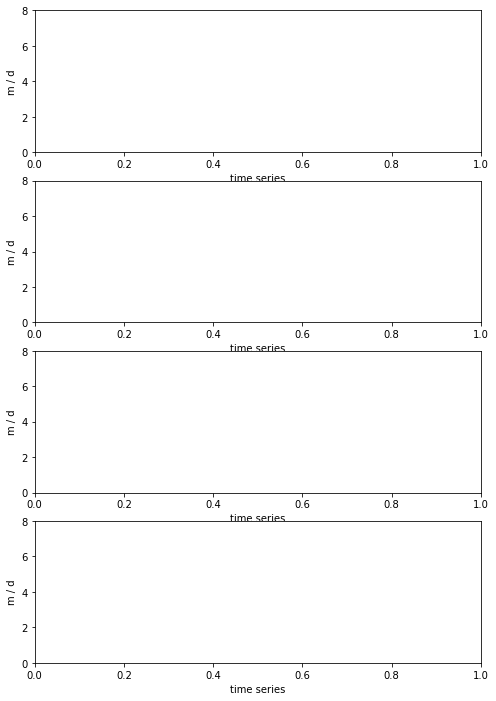

In [6]:
%%time

# Create time-series plots for speeds at the centers of the above four respective lateral transects

# Remember that n16s is how many 16-day-interval results we have; and these are m[0], ..., m[n16s - 1]
maxSpeed = 8.
colorsequence = ['red', 'orange', 'green', 'cyan']
fig,axes = plt.subplots(nTransects)
fig.set_size_inches(8,12)
for i in tr_idcs: axes[i].set(ylim=(0., maxSpeed), xlabel='time series', ylabel = 'm / d')
# plt.subplots_adjust(hspace=0.6)

for t in tr_idcs: 
    xMid = utm0[t][0] + (number_of_postings[t]/2.)*relative_postings[t][0]    # These must start at utm0 and add a certain 
    yMid = utm0[t][1] + (number_of_postings[t]/2.)*relative_postings[t][1]    #   number of the relative_postings vectors
    y = vv.sel(y=yMid,x=xMid,method='nearest').values 
    axes[t].plot(time, y, 'o', color=colorsequence[t])
        

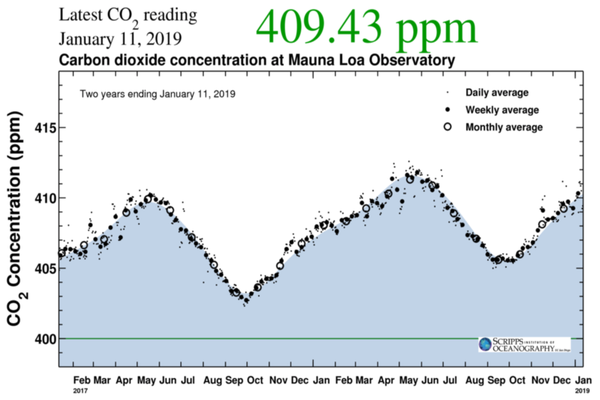

In [7]:
# Say those sharp corners remind me of something...
ShowLocalImage('./', 'keeling.png', 600, 400)

In [8]:
# Establishes lgo_mask varies in time
if False:
    xice = 702
    yice = 402
    for i in range(10):                                          # time slices
        lgoval = lgo.isel(y=yice,x=xice,time=i).values           # most 0 (glacier) but one 1 (land)
        vvval = vv.isel(y=yice,x=xice,time=i).values             # some 'no data' values at -9999.
        corrval = corr.isel(y=yice,x=xice,time=i).values         # ranges .51 to .89
        northval = north.isel(y=yice).values                     # consistent
        eastval = east.isel(x=xice).values                       # consistent
        print(lgoval, vvval, corrval, northval, eastval)

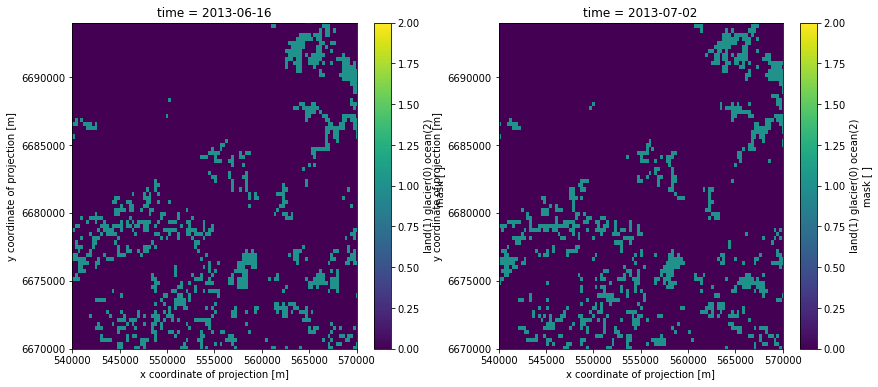

In [9]:
# lgo_mask with consecutive times: Slight differences apparent
# This makes it intrinsically more difficult to settle on a set of for-sure-this-is-moving-ice pixels
if True:
    fig,axes = plt.subplots(1, 2)
    lgo.isel(time=5).plot(ax=axes[0])
    lgo.isel(time=6).plot(ax=axes[1])
    fig.set_size_inches(14,6)
    axes[0].set(xlim=(540000,570000),ylim=(6670000,6694000))
    axes[1].set(xlim=(540000,570000),ylim=(6670000,6694000))

In [10]:
# lgo has both Parameters (particularly 'data') and Attributes (particularly 'values')
if False: 
    print(lgo.data)
    print('\n ------------------- \n')
    print(lgo.values)

In [11]:
%%time

# migrate to supplement...
# prints time used when the cell is done running
# use the timer to ingest this time into a program...

start_time = timeit.default_timer()

# Here we average time series mask values (0 for ice, 1 for land) across time-series using values.mean()
if True:
    for j in range(401,403):
        for i in range(701,703):
            print(lgo.isel(y=j,x=i).data.mean())

# ...as here the time interval comes programmatically off the timer
print('\n', timeit.default_timer() - start_time, '\n\ncompare with...\n')

1.0
0.7450980392156863
0.9921568627450981
0.596078431372549

 0.0037009920924901962 

compare with...

CPU times: user 4.45 ms, sys: 31 µs, total: 4.48 ms
Wall time: 3.86 ms


## Part 3. Entire-scene analysis

* Using the entire scene is the objective
  * Start with a single UTM coordinate: center of first transect shown above
  * integer indices? (open challenge)
  * Subsets of DataArrays are DataArrays
    * ...but .data or .values are numpy ndarrays (immutable vectors)
    * 'lists without commas'
* Verify no-data value = -9999. and convert these to nan
* Use xarray.DataArray.mean(dim) and .std(dim) where dim indicates axis of the calculation
  * ...and verify!
* Count how many good data values
* Count lgo glacier values

In [12]:
%%time

if True:
    # Operating on a single pixel...
    #   choosing the mid-point of the lower transect, closest to Malaspina
    xMid = utm0[0][0] + (number_of_postings[0]/2.)*relative_postings[0][0]    # These must start at utm0 and add a certain 
    yMid = utm0[0][1] + (number_of_postings[0]/2.)*relative_postings[0][1]    #   number of the relative_postings vectors
    print('UTM of point of interest is', xMid, yMid, 'as easting - northing\n')
    s = vv.sel(x=xMid,y=yMid,method='nearest')           # selects a time series at one location (xMid, yMid)
    ss = s.where(s.data >= 0.)                           # substitutes nan for -9999. no data value
    # each of the following does something relevant: 
    #   print(s.values)                           # prints speeds as an ndarray (not a list; no commas!)
    #   print(s)                                  # describes DataArray (since it was derived from m['vv_masked'])        
    #   s.plot()                                  # uses .plot() native to DataArray to show a plot (-9999 to 30 m/d)
    #   print(ss.values)                          # shows the nan value substitution in ss
    #   print(ss.mean(skipna=True).values)        # use DataArray .mean() to ignore nans and print a mean of 4.127929 (sd 1.0109311)
    #   print(np.std([1., 2., 3.]))               # sidebar numpy operating on a list
    #   print(s.x, '\n')
    #   print(s, '\n')
    #   print(s.masking_info, '\n')
    #   print(s['time'])
    #   dirobj(s)
    #   dirobj(s.x)
    #   print(ss.std(), ss.mean(), ss.std()/ss.mean())
    #   print(ss.data)                                    # prints all 255 values
    print(ss.mean().data)                                 # about 1                    
    print(ss.std().data)                                  # about 4
    print(ss.std().data/ss.mean().data) 
    # print(dirobj(ss))
    print(ss.count('time').data)                          # 78 values (i.e. not nan)
    print(ss.sum().data)                                  # sum of all 78 values

UTM of point of interest is 530599.7680965028 6661741.749429959 as easting - northing

4.1279296875
1.010931134223938
0.24490027949971907
78
321.978515625
CPU times: user 7 ms, sys: 0 ns, total: 7 ms
Wall time: 32.2 ms


In [13]:
print(vv.shape)

(255, 829, 840)


In [14]:
import warnings
warnings.filterwarnings("ignore",category=RuntimeWarning)

In [15]:
lgo1 = lgo.where(lgo.data >= 0.)
lgo2 = lgo1.where(lgo1.data <= 2.)
lgo3 = lgo2.mean('time')
lgo4 = lgo3.where(lgo3.data <= 0.2)

In [16]:
vv1=vv.where(vv.data >= 0.).mean('time')
vv2=vv.where(vv.data >= 0.).std('time')

In [17]:
print(vv1.isel(x=537,y=319).data)
print(vv2.isel(x=537,y=319).data)

0.08344171
0.097960316


In [18]:
vv3=vv2/vv1
vv3.shape

(829, 840)

(6630000, 6730000)

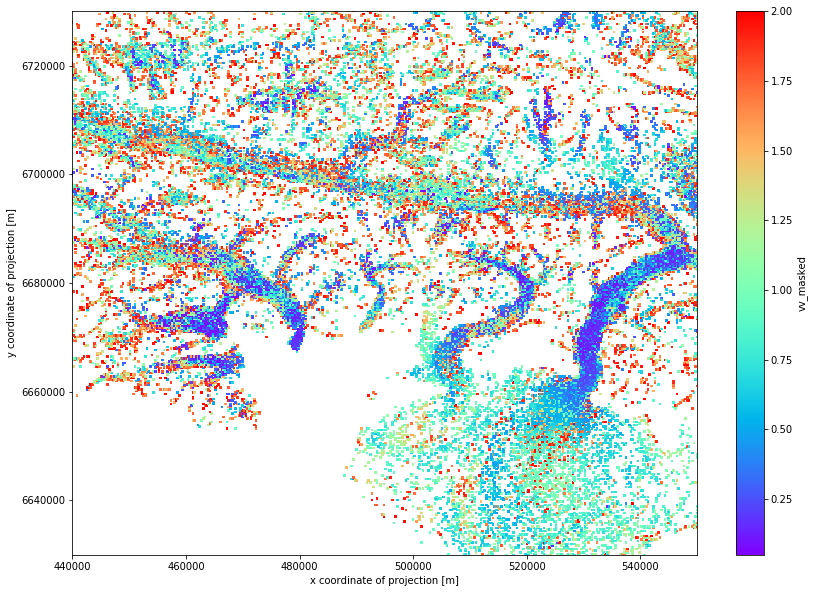

In [19]:
vv4 = vv3.where(vv3.data < 2.0)
vv5 = vv4.where(vv4.data > 0.05)
vv6 = vv5.where(lgo4.data >= 0.0)
vv6.plot(figsize=(14,10),cmap=plt.cm.rainbow,vmin=0.05, vmax=2.0)
plt.xlim(440000,550000)
plt.ylim(6630000,6730000)

(6630000, 6730000)

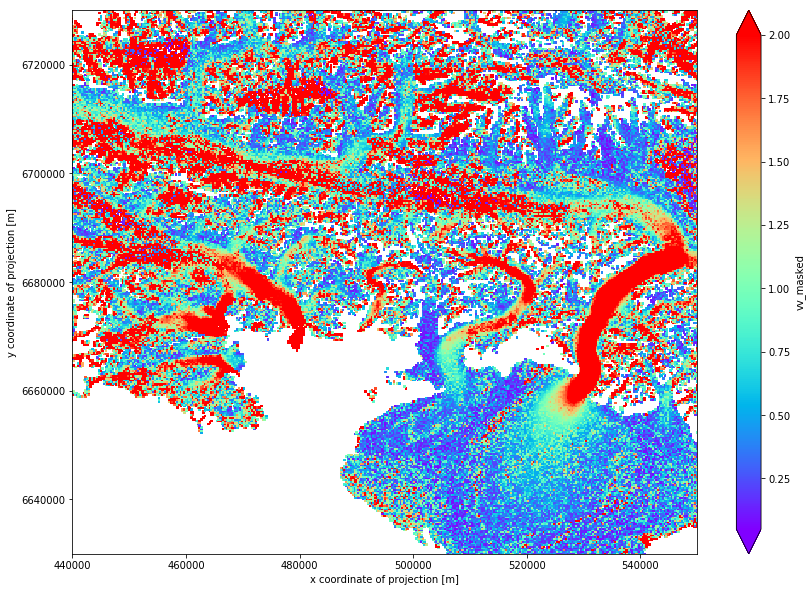

In [20]:
vvlgo1 = vv1.where(lgo4.data >= 0.)
vvlgo1.plot(figsize=(14,10),cmap=plt.cm.rainbow,vmin=0.05, vmax=2.0)
plt.xlim(440000,550000)
plt.ylim(6630000,6730000)